In [1]:
import os
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from sklearn.model_selection import train_test_split

In [2]:
image_dir = os.path.join("data", "data_png" ,"data")
mask_dir = os.path.join("data" , "data_png","masks")


In [3]:
image_file = os.listdir(image_dir)
mask_file = os.listdir(mask_dir)
print("number of image is " , len(image_file))
print("number of masks is ", len(mask_file))

number of image is  200
number of masks is  200


In [4]:
data = pd.DataFrame()
data['image'] = [os.path.join(image_dir , file) for file in image_file]
data["masks"] = [os.path.join(mask_dir , file) for file in mask_file[:200]]


In [5]:
data.head()

,image,masks
0,data\data_png\data\image_1.png,data\data_png\masks\task-44727993-annotation-1...
1,data\data_png\data\image_10.png,data\data_png\masks\task-44727994-annotation-1...
2,data\data_png\data\image_100.png,data\data_png\masks\task-44727995-annotation-1...
3,data\data_png\data\image_101.png,data\data_png\masks\task-44727996-annotation-1...
4,data\data_png\data\image_102.png,data\data_png\masks\task-44727997-annotation-1...


In [6]:
assert (data['image'] == data['image'].sort_values()).sum() == 200

In [7]:
assert (data['masks'] == data['masks'].sort_values()).sum() == 200

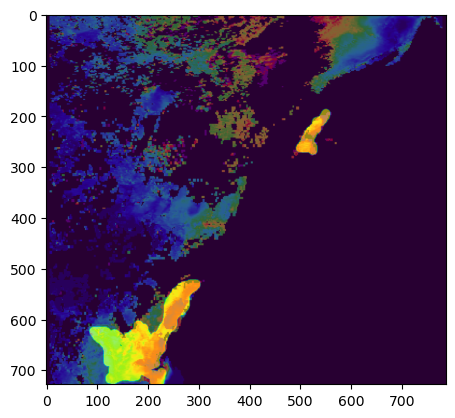

In [8]:
test_id = 0 
test_image = data['image'][test_id]
test_mask = data['masks'][test_id]
test_image = cv2.imread(test_image,cv2.COLOR_BGR2RGB)
test_mask = cv2.imread(test_mask,cv2.COLOR_BGR2RGB)
plt.imshow(test_image)
plt.imshow(test_mask,alpha=0.6)

In [9]:
test_mask.shape

(728, 787)

In [8]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

In [9]:
def read_image(image_file):
    image = tf.io.read_file(image_file)
    image = tf.io.decode_png(image , channels=3)
    image = tf.image.resize(image , (512,512))
    image = image.astype(float)
    return image

In [10]:
def read_mask(file_name):
    mask = tf.io.read_file(file_name)
    mask = tf.io.decode_jpeg(mask,channels=0)
    mask = tf.image.resize(mask , (512,512))
    mask = tf.convert_to_tensor(mask)
    mask = tf.where(mask > 0.0 , 1.0 , mask)
    mask = mask.astype(float)
    return mask

In [12]:
mask = read_mask(data['masks'][0])

In [13]:
mask.shape

TensorShape([512, 512, 1])

In [14]:
pd.Series(mask.numpy().ravel()).value_counts()

0.0    252539
1.0      9605
Name: count, dtype: int64

In [15]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    return x

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    x = tf.keras.layers.Dropout(0.5)(x)
    return x

def build_resnet50_unet(input_shape):
    """ Input """
    inputs = Input(input_shape)

    """ Pre-trained ResNet50 Model """
    resnet50 = ResNet50(include_top=False, weights="imagenet", input_tensor=inputs)

    """ Encoder """
    s1 = resnet50.get_layer("input_1").output           ## (512 x 512)
    s2 = resnet50.get_layer("conv1_relu").output        ## (256 x 256)
    s3 = resnet50.get_layer("conv2_block3_out").output  ## (128 x 128)
    s4 = resnet50.get_layer("conv3_block4_out").output  ## (64 x 64)

    """ Bridge """
    b1 = resnet50.get_layer("conv4_block6_out").output  ## (32 x 32)

    """ Decoder """
    d1 = decoder_block(b1, s4, 512)                     ## (64 x 64)
    d2 = decoder_block(d1, s3, 256)                     ## (128 x 128)
    d3 = decoder_block(d2, s2, 128)                     ## (256 x 256)
    d4 = decoder_block(d3, s1, 64)                      ## (512 x 512)

    """ Output """
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="ResNet50_U-Net")
    return model


In [16]:
input_shape = (512, 512, 3)
model = build_resnet50_unet(input_shape)

In [18]:
model.summary()

Model: "ResNet50_U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 518, 518, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 256, 256, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                     

In [17]:
#build dataset pipeline 
train , valid = train_test_split(data , test_size=0.1,shuffle=True , random_state=42)
train.to_csv("train.csv",index=False)
valid.to_csv("test.csv",index=False)
data.to_csv("data.csv", index=False )
pd.read_csv("data.csv").head()

,image,masks
0,data\data_png\data\image_1.png,data\data_png\masks\task-44727993-annotation-1...
1,data\data_png\data\image_10.png,data\data_png\masks\task-44727994-annotation-1...
2,data\data_png\data\image_100.png,data\data_png\masks\task-44727995-annotation-1...
3,data\data_png\data\image_101.png,data\data_png\masks\task-44727996-annotation-1...
4,data\data_png\data\image_102.png,data\data_png\masks\task-44727997-annotation-1...


In [18]:
mask = read_mask(data["masks"][0])
mask.shape

TensorShape([512, 512, 1])

In [19]:
def process(line):
    defaults = ['image',"masks"]
    fileds = tf.io.decode_csv(line , record_defaults=defaults)
    image = read_image(fileds[0])
    mask = read_mask(fileds[1])
    return image , mask

In [20]:
trainset = tf.data.TextLineDataset("train.csv", num_parallel_reads=tf.data.AUTOTUNE).skip(1)
trainset = trainset.map(process)
trainset = trainset.batch(2)
#for valid
validset = tf.data.TextLineDataset("test.csv", num_parallel_reads=tf.data.AUTOTUNE).skip(1)
validset = validset.map(process)
validset = validset.batch(2)

In [21]:
for x ,  y in trainset.take(1):
    model(x)

KeyboardInterrupt: 

In [22]:
model.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-3) , loss=tf.losses.BinaryCrossentropy(),
              metrics=["acc"])

In [24]:
valid.shape[0]

20

In [103]:
try :
    history = model.fit(trainset ,epochs=3,validation_data=validset,  )
except KeyboardInterrupt:
    pass

Epoch 1/3
90/90 [==============================] - 1608s 18s/step - loss: 0.0890 - acc: 0.9652 - val_loss: 0.1167 - val_acc: 0.9434
Epoch 2/3
90/90 [==============================] - 1581s 18s/step - loss: 0.0858 - acc: 0.9660 - val_loss: 0.1041 - val_acc: 0.9526
Epoch 3/3
37/90 [===========>..................] - ETA: 14:22:47 - loss: 0.0849 - acc: 0.9660

In [27]:
history = pd.DataFrame(history.history)
history

,loss,acc,val_loss,val_acc
0,0.242879,0.911815,109.962975,0.050670
1,0.125076,0.955644,2.991612,0.767652
2,0.106652,0.960165,0.743454,0.859795
3,0.097927,0.962770,0.437880,0.886590
4,0.092127,0.964337,0.168673,0.932789


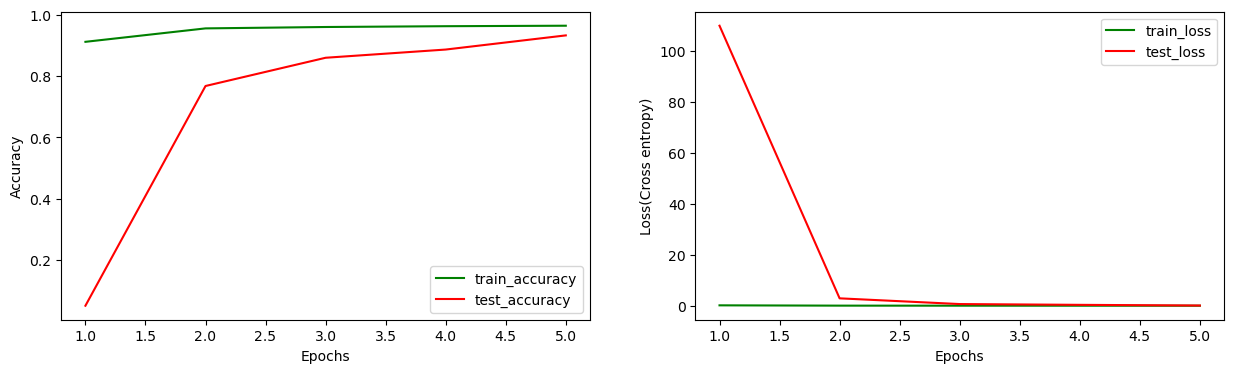

In [39]:
fig , (ax1 , ax2) = plt.subplots(1 , 2, figsize=(15,4))
ax1.plot(np.arange(1,6) , history['acc'], color ='g',label="train_accuracy")
ax1.plot(np.arange(1,6) , history['val_acc'], color = "r", label="val_accuracy")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Accuracy")
ax1.legend(['train_accuracy' , "test_accuracy"])
ax2.plot(np.arange(1,6) , history['loss'], color ='g',label="train_loss")
ax2.plot(np.arange(1,6) , history['val_loss'], color = "r", label="val_loss")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Loss(Cross entropy)")
ax2.legend(['train_loss' , "test_loss"])

In [40]:
model.save("model.hd5")

INFO:tensorflow:Assets written to: model.hd5\assets


INFO:tensorflow:Assets written to: model.hd5\assets


In [42]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model("model.hd5") # path to the SavedModel directory
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

In [ ]:
##########################################################

In [2]:
model = tf.keras.models.load_model("model.hd5")

In [3]:
test_image = cv2.imread("data/data_png/data/image_10.png",cv2.COLOR_BGR2RGB)
test_image = cv2.resize(test_image ,(512 ,512))
test_image = np.expand_dims(test_image,0)
pred = model.predict(test_image)

1/1 [==============================] - 3s 3s/step


In [4]:
pred

array([[[[1.5271251e-03],
         [3.9797759e-04],
         [2.7140914e-04],
         ...,
         [9.7823050e-03],
         [4.4032498e-03],
         [5.3811166e-03]],

        [[4.3673889e-04],
         [5.0658342e-05],
         [3.1826341e-05],
         ...,
         [1.0478268e-02],
         [2.8776708e-03],
         [3.3894626e-03]],

        [[2.8890764e-04],
         [2.6081696e-05],
         [1.6868406e-05],
         ...,
         [1.7430989e-02],
         [3.8979815e-03],
         [4.0549175e-03]],

        ...,

        [[9.3836588e-04],
         [1.7879751e-04],
         [1.3348681e-04],
         ...,
         [2.2206568e-04],
         [2.5264037e-04],
         [8.3599152e-04]],

        [[1.1084877e-03],
         [2.3569877e-04],
         [1.8615618e-04],
         ...,
         [2.5914243e-04],
         [2.8893023e-04],
         [9.1084285e-04]],

        [[2.6568561e-03],
         [9.2323695e-04],
         [7.8519929e-04],
         ...,
         [9.6112961e-04],
        

In [152]:
threshold = 0.5
binary_mask = np.where(pred > threshold, 1, 0)

In [153]:
# Convert the binary mask to an image
binary_mask_img = np.squeeze(binary_mask) * 255
binary_mask_img = binary_mask_img.astype(np.uint8)

In [154]:
binary_mask_img

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [155]:
mask.shape

(1, 512, 512)

Text(0.5, 1.0, 'actual mask')

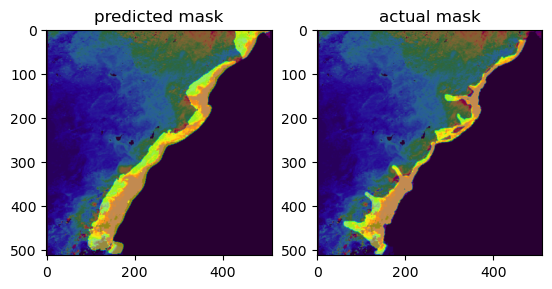

In [156]:
fig , (ax1 , ax2) = plt.subplots(1,2)
ax1.imshow(test_image.squeeze(0).astype(int))
ax1.imshow(binary_mask_img , alpha=0.6)
ax1.set_title("predicted mask")
ax2.imshow(test_image.squeeze(0).astype(int))
ax2.imshow(cv2.resize(plt.imread(data['masks'][10]),(512,512)),alpha=0.6)
ax2.set_title("actual mask")

In [1]:
###################################END############################

In [157]:
new_model = tf.keras.models.Sequential()
new_model.add(model)
new_model.add(tf.keras.layers.Lambda(lambda x : tf.where(x > 0.5 , 1, 0)))


In [159]:
new_model(test_image).shape

TensorShape([1, 512, 512, 1])

In [160]:
new_model.save("get_mask.hd5")
converter = tf.lite.TFLiteConverter.from_keras_model(new_model) # path to the SavedModel directory
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

# Save the model.
with open('model_mask.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: get_mask.hd5\assets


INFO:tensorflow:Assets written to: get_mask.hd5\assets


INFO:tensorflow:Assets written to: C:\Users\ADMINI~1\AppData\Local\Temp\tmp5oikmfa6\assets


INFO:tensorflow:Assets written to: C:\Users\ADMINI~1\AppData\Local\Temp\tmp5oikmfa6\assets


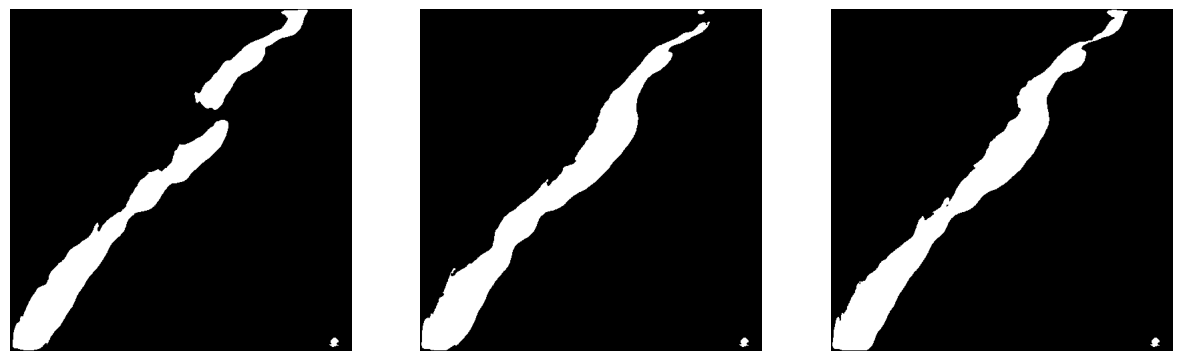

In [183]:
fig , axes = plt.subplots(1,3,figsize=(15,5))
axes = axes.flatten()
for i , image in enumerate(['image1.jpeg', 'imge2.jpeg','image3.jpeg']):
    plot_image = cv2.imread(image , cv2.COLOR_BGR2RGB)
    plot_image = plot_image[50:-50,70:-70,:]
    plot_image = cv2.resize(plot_image , (512,512))
    plot_image = np.expand_dims(plot_image , axis=0)
    mask = new_model(plot_image)
    #axes[i].imshow(plot_image.squeeze(0))
    mask = tf.logical_not(mask.astype(bool))
    axes[i].imshow(mask.numpy().squeeze(0),cmap="binary")
    axes[i].axis("off")


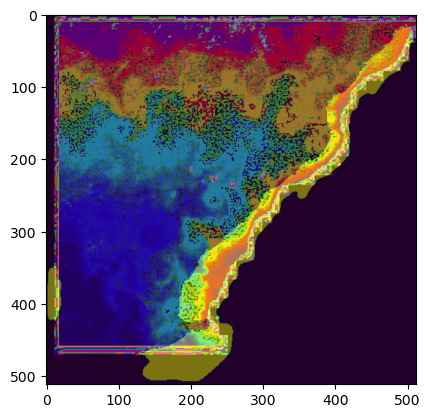

In [187]:
plot_image = cv2.imread("image4.jpeg", cv2.COLOR_BGR2RGB)
plot_image = cv2.resize(plot_image , (512,512))
plot_image = np.where(plot_image==255 , 0 , plot_image)
plot_image = np.expand_dims(plot_image , axis=0)
mask = new_model(plot_image)
plt.imshow(plot_image.squeeze(0))
plt.imshow(mask.numpy().squeeze(0), alpha=0.5)

In [177]:
plot_image

array([[[[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 254, 255],
         [255, 254, 255],
         [255, 253, 255]],

        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [254, 254, 255],
         [254, 254, 255],
         [255, 254, 255]],

        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [254, 255, 254],
         [254, 255, 254],
         [255, 254, 255]],

        ...,

        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],

        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],

        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
        

In [ ]:
##########################END###############################

In [2]:
import numpy as np
import tensorflow as tf
import cv2
model = tf.keras.models.load_model("get_mask.hd5")

In [11]:
model.save("mask_model.h5")

In [12]:
%%writefile file.py
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import cv2
model = tf.keras.models.load_model("mask_model.h5")
def save_mask(image):
    image = cv2.imread(image , cv2.COLOR_BGR2RGB)
    image = cv2.resize(image ,(512, 512))
    image = np.expand_dims(image , axis=0)
    mask = model(image)
    plt.imshow(mask.numpy().squeeze(0),cmap='binary')
    plt.savefig("mask.png")


Overwriting file.py


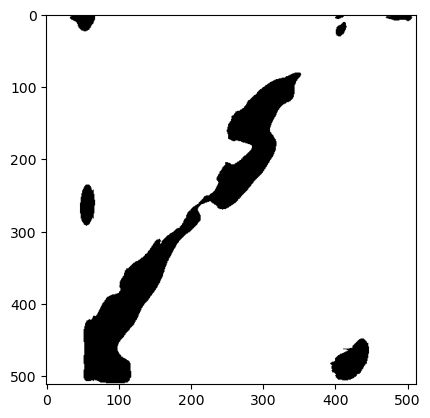

In [13]:
save_mask("image1.jpeg")

In [14]:
tf.__version__

'2.11.0'

In [6]:
image = "image1.jpeg"
image = cv2.imread(image , cv2.COLOR_BGR2RGB)
image = cv2.resize(image ,(512, 512))
image = np.expand_dims(image , axis=0)

In [7]:
model(image.astype(float))

<tf.Tensor: shape=(1, 512, 512, 1), dtype=float32, numpy=
array([[[[3.9431327e-03],
         [1.9236497e-03],
         [1.6360228e-03],
         ...,
         [1.1820469e-01],
         [9.2030905e-02],
         [7.7319644e-02]],

        [[1.2799182e-03],
         [3.3731214e-04],
         [2.1806608e-04],
         ...,
         [1.3714464e-01],
         [9.1893837e-02],
         [1.0249164e-01]],

        [[1.0117452e-03],
         [1.4226204e-04],
         [6.8445908e-05],
         ...,
         [2.2194922e-01],
         [1.3560596e-01],
         [1.2603885e-01]],

        ...,

        [[2.9436511e-03],
         [6.3380552e-04],
         [3.3162843e-04],
         ...,
         [1.9169716e-03],
         [3.8439971e-03],
         [1.5757730e-02]],

        [[7.3414748e-03],
         [1.8506224e-03],
         [1.1641658e-03],
         ...,
         [3.5627275e-03],
         [7.2841831e-03],
         [2.3294365e-02]],

        [[1.8196659e-02],
         [1.2109749e-02],
         [1.0367

In [18]:
mask = _

In [19]:
mask.shape

TensorShape([1, 512, 512, 1])

In [20]:
np.unique(image)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [24]:
image = "image1.jpeg"
image = cv2.imread(image , cv2.COLOR_BGR2RGB)
image = cv2.resize(image ,(257,257))
image = np.expand_dims(image , axis=0)

In [25]:
anthor_model = tf.keras.models.Sequential()
anthor_model.add(tf.keras.layers.Input(shape=(257,257,3)))
anthor_model.add(tf.keras.layers.Resizing(512,512))
anthor_model.add(model)
anthor_model.add(tf.keras.layers.Resizing(257,257))

In [28]:
anthor_model(image).numpy().shape

(1, 257, 257, 1)

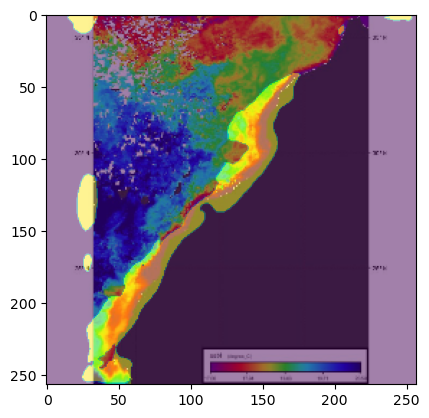

In [29]:
plt.imshow(image.squeeze(0))
plt.imshow(anthor_model(image).numpy().squeeze(0),alpha=0.5)

In [30]:
converter = tf.lite.TFLiteConverter.from_keras_model(anthor_model) # path to the SavedModel directory
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

# Save the model.
with open('model_mask2.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\ADMINI~1\AppData\Local\Temp\tmpidt0qy0p\assets


INFO:tensorflow:Assets written to: C:\Users\ADMINI~1\AppData\Local\Temp\tmpidt0qy0p\assets


In [31]:
from tflite_support import flatbuffers
from tflite_support import metadata as _metadata
from tflite_support import metadata_schema_py_generated as _metadata_fb

""" ... """
"""Creates the metadata for an image classifier."""

# Creates model info.
model_meta = _metadata_fb.ModelMetadataT()
model_meta.name = "Image segmentation using u-net"
model_meta.description = ("Identify which region to have upwelling "
                          )
model_meta.version = "v1"
model_meta.author = "TensorFlow"
model_meta.license = ("Apache License. Version 2.0 "
                      "http://www.apache.org/licenses/LICENSE-2.0.")

In [32]:
# Creates input info.
input_meta = _metadata_fb.TensorMetadataT()

# Creates output info.
output_meta = _metadata_fb.TensorMetadataT()

In [33]:
input_meta.name = "image"
input_meta.description = (
    "Input image to be classified. The expected image is {0} x {1}, with "
    "three channels (red, blue, and green) per pixel. Each value in the "
    "tensor is a single byte between 0 and 255.".format(257,257))
input_meta.content = _metadata_fb.ContentT()
input_meta.content.contentProperties = _metadata_fb.ImagePropertiesT()
input_meta.content.contentProperties.colorSpace = (
    _metadata_fb.ColorSpaceType.RGB)
input_meta.content.contentPropertiesType = (
    _metadata_fb.ContentProperties.ImageProperties)
input_normalization = _metadata_fb.ProcessUnitT()
input_normalization.optionsType = (
    _metadata_fb.ProcessUnitOptions.NormalizationOptions)
input_normalization.options = _metadata_fb.NormalizationOptionsT()
input_normalization.options.mean = [127.5]
input_normalization.options.std = [127.5]
input_meta.processUnits = [input_normalization]
input_stats = _metadata_fb.StatsT()
input_stats.max = [255]
input_stats.min = [0]
input_meta.stats = input_stats

In [35]:
import os

In [36]:
# Creates output info.
output_meta = _metadata_fb.TensorMetadataT()
output_meta.name = "probability"
output_meta.description = "Probabilities of the being masked"
output_meta.content = _metadata_fb.ContentT()
output_meta.content.content_properties = _metadata_fb.FeaturePropertiesT()
output_meta.content.contentPropertiesType = (
    _metadata_fb.ContentProperties.FeatureProperties)
output_stats = _metadata_fb.StatsT()
output_stats.max = [1.0]
output_stats.min = [0.0]
output_meta.stats = output_stats
label_file = _metadata_fb.AssociatedFileT()
#label_file.name = os.path.basename("your_path_to_label_file")
label_file.description = "Labels for objects that the model can recognize."
label_file.type = _metadata_fb.AssociatedFileType.TENSOR_AXIS_LABELS
output_meta.associatedFiles = [label_file]

In [37]:
# Creates subgraph info.
subgraph = _metadata_fb.SubGraphMetadataT()
subgraph.inputTensorMetadata = [input_meta]
subgraph.outputTensorMetadata = [output_meta]
model_meta.subgraphMetadata = [subgraph]

b = flatbuffers.Builder(0)
b.Finish(
    model_meta.Pack(b),
    _metadata.MetadataPopulator.METADATA_FILE_IDENTIFIER)
metadata_buf = b.Output()

In [39]:
anthor_model.save("anthor_model.h5")

In [47]:
populator = _metadata.MetadataPopulator.with_model_buffer("model.hd5")
populator.load_metadata_buffer(metadata_buf)
#populator.load_associated_files(["your_path_to_label_file"])
populator.populate()

ValueError: The model provided does not have the expected identifier, and may not be a valid TFLite model.

In [4]:
from tflite_support import metadata
metadata._pywrap_metadata_version.GetMinimumMetadataParserVersion()

TypeError: GetMinimumMetadataParserVersion(): incompatible function arguments. The following argument types are supported:
    1. (arg0: str) -> str

Invoked with: 

In [11]:
import tflite_support
tflite_support.metadata._pywrap_metadata_version.GetMinimumMetadataParserVersion("2.10.0")

''

In [12]:
import tensorflow as tf
print(tf.__version__)
print(tf._major_api_version)

2.11.0
2


In [13]:
tf.lite.__version__

AttributeError: module 'tensorflow._api.v2.lite' has no attribute '__version__'

In [57]:
from tflite_support.metadata_writers import object_detector,image_segmenter
from tflite_support.metadata_writers import writer_utils
from tflite_support import metadata

ObjectDetectorWriter = image_segmenter.MetadataWriter
_MODEL_PATH = "model_mask2.tflite"
_LABEL_FILE = "labelmap2.txt"
_SAVE_TO_PATH = "model_mask3.tflite"

writer = ObjectDetectorWriter.create_for_inference(
    writer_utils.load_file(_MODEL_PATH), [127.5], [127.5], [_LABEL_FILE])
writer_utils.save_file(writer.populate(), _SAVE_TO_PATH)

# Verify the populated metadata and associated files.
displayer = metadata.MetadataDisplayer.with_model_file(_SAVE_TO_PATH)
print("Metadata populated:")
print(displayer.get_metadata_json())
print("Associated file(s) populated:")
print(displayer.get_packed_associated_file_list())

Metadata populated:
{
  "name": "ImageSegmenter",
  "description": "Semantic image segmentation predicts whether each pixel of an image is associated with a certain class.",
  "subgraph_metadata": [
    {
      "input_tensor_metadata": [
        {
          "name": "image",
          "description": "Input image to be segmented.",
          "content": {
            "content_properties_type": "ImageProperties",
            "content_properties": {
              "color_space": "RGB"
            }
          },
          "process_units": [
            {
              "options_type": "NormalizationOptions",
              "options": {
                "mean": [
                  127.5
                ],
                "std": [
                  127.5
                ]
              }
            }
          ],
          "stats": {
            "max": [
              1.0
            ],
            "min": [
              -1.0
            ]
          }
        }
      ],
      "output_tensor_metad

In [52]:
model_meta = _metadata_fb.ModelMetadataT()
model_meta.name = "segmentation"
model_meta.description = (
    "Identify which of a known set of objects might be present and provide "
    "information about their positions within the given image or a video "
    "stream.")

# Creates input info.
input_meta = _metadata_fb.TensorMetadataT()
input_meta.name = "image"
input_meta.content = _metadata_fb.ContentT()
input_meta.content.contentProperties = _metadata_fb.ImagePropertiesT()
input_meta.content.contentProperties.colorSpace = (
    _metadata_fb.ColorSpaceType.RGB)
input_meta.content.contentPropertiesType = (
    _metadata_fb.ContentProperties.ImageProperties)
input_normalization = _metadata_fb.ProcessUnitT()
input_normalization.optionsType = (
    _metadata_fb.ProcessUnitOptions.NormalizationOptions)
input_normalization.options = _metadata_fb.NormalizationOptionsT()
input_normalization.options.mean = [127.5]
input_normalization.options.std = [127.5]
input_meta.processUnits = [input_normalization]
input_stats = _metadata_fb.StatsT()
input_stats.max = [255]
input_stats.min = [0]
input_meta.stats = input_stats

# Creates outputs info.
output_location_meta = _metadata_fb.TensorMetadataT()
output_location_meta.name = "location"
output_location_meta.description = "The locations of the detected boxes."
output_location_meta.content = _metadata_fb.ContentT()
output_location_meta.content.contentPropertiesType = (
    _metadata_fb.ContentProperties.BoundingBoxProperties)
output_location_meta.content.contentProperties = (
    _metadata_fb.BoundingBoxPropertiesT())
#output_location_meta.content.contentProperties.index = [1, 0, 3, 2]
output_location_meta.content.contentProperties.type = (
    _metadata_fb.BoundingBoxType.BOUNDARIES)
output_location_meta.content.contentProperties.coordinateType = (
    _metadata_fb.CoordinateType.RATIO)
output_location_meta.content.range = _metadata_fb.ValueRangeT()
output_location_meta.content.range.min = 0
output_location_meta.content.range.max = 1

output_class_meta = _metadata_fb.TensorMetadataT()
output_class_meta.name = "category"
output_class_meta.description = "The categories of the detected boxes."
output_class_meta.content = _metadata_fb.ContentT()
output_class_meta.content.contentPropertiesType = (
    _metadata_fb.ContentProperties.FeatureProperties)
output_class_meta.content.contentProperties = (
    _metadata_fb.FeaturePropertiesT())
output_class_meta.content.range = _metadata_fb.ValueRangeT()
output_class_meta.content.range.min = 0
output_class_meta.content.range.max = 1
label_file = _metadata_fb.AssociatedFileT()
label_file.name = os.path.basename("label.txt")
label_file.description = "Label of objects that this model can recognize."
label_file.type = _metadata_fb.AssociatedFileType.TENSOR_VALUE_LABELS
output_class_meta.associatedFiles = [label_file]

output_score_meta = _metadata_fb.TensorMetadataT()
output_score_meta.name = "score"
output_score_meta.description = "The scores of the detected boxes."
output_score_meta.content = _metadata_fb.ContentT()
output_score_meta.content.contentPropertiesType = (
    _metadata_fb.ContentProperties.FeatureProperties)
output_score_meta.content.contentProperties = (
    _metadata_fb.FeaturePropertiesT())
output_score_meta.content.range = _metadata_fb.ValueRangeT()
output_score_meta.content.range.min = 0
output_score_meta.content.range.max = 1

output_number_meta = _metadata_fb.TensorMetadataT()
output_number_meta.name = "number of detections"
output_number_meta.description = "The number of the detected boxes."
output_number_meta.content = _metadata_fb.ContentT()
output_number_meta.content.contentPropertiesType = (
    _metadata_fb.ContentProperties.FeatureProperties)
output_number_meta.content.contentProperties = (
    _metadata_fb.FeaturePropertiesT())

# Creates subgraph info.
group = _metadata_fb.TensorGroupT()
group.name = "detection result"
group.tensorNames = [
    output_location_meta.name, output_class_meta.name,
    output_score_meta.name
]
subgraph = _metadata_fb.SubGraphMetadataT()
subgraph.inputTensorMetadata = [input_meta]
subgraph.outputTensorMetadata = [
    output_location_meta, output_class_meta, output_score_meta,
    output_number_meta
]
subgraph.outputTensorGroups = [group]
model_meta.subgraphMetadata = [subgraph]

b = flatbuffers.Builder(0)
b.Finish(
    model_meta.Pack(b),
    _metadata.MetadataPopulator.METADATA_FILE_IDENTIFIER)
metadata_buf = b.Output()

Exception ignored in: <function _MetadataPopulatorWithBuffer.__del__ at 0x0000016E96B21790>
Traceback (most recent call last):
  File "c:\Users\Administrator\anaconda3\lib\site-packages\tensorflow_lite_support\metadata\python\metadata.py", line 682, in __del__
    if os.path.exists(self._model_file):
AttributeError: '_MetadataPopulatorWithBuffer' object has no attribute '_model_file'


In [53]:
populator = _metadata.MetadataPopulator.with_model_file('model_mask2.tflite')
populator.load_metadata_buffer(metadata_buf)
populator.load_associated_files(['/content/drive/My Drive/Detecto Tutorial/models/research/fine_tuned_model/labelmap.txt'])
populator.populate()

ValueError: The number of output tensors (1) should match the number of output tensor metadata (4)

In [64]:
import tensorflow as tf
import pathlib

# Define the input and output details of the model
input_details = [{
    'name': 'input',
    'shape': [1, 512, 512, 3],
    'dtype': tf.float32,
    'quantization': (0, 255)
}]

output_details = [{
    'name': 'output',
    'shape': [1, 512, 512, 1],
    'dtype': tf.float32,
    'quantization': (0, 1)
}]

# Build and train your TensorFlow model

# Convert the TensorFlow model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_saved_model("model.hd5")
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

# Save the model with metadata
metadata =  _metadata_fb.ModelMetadataT()
metadata.name = 'segmentation_model'
metadata.description = 'A TensorFlow Lite model for image segmentation.'
metadata.version = '1.0'
metadata.author = 'Your Name'

# Define the input metadata
input_metadata = {
    'input': {
        'name': 'input',
        'description': 'The input image for segmentation.',
        'type': 'IMAGE',
        'tensorType': 'UINT8',
        'shape': [1, 512, 512, 3],
        'quantization': {
            'min': 0,
            'max': 255
        }
    }
}

# Define the output metadata
output_metadata = {
    'output': {
        'name': 'output',
        'description': 'The segmented image.',
        'type': 'IMAGE',
        'tensorType': 'FLOAT32',
        'shape': [1, 512, 512, 1],
        'quantization': {
            'min': 0,
            'max': 1
        }
    }
}

# Save the model with metadata to a file
model_path = pathlib.Path('segmentation_model.tflite')
model_path.write_bytes(tflite_model)

# Save the metadata to a file
metadata_path = pathlib.Path('segmentation_model_metadata.tflite')
metadata_buffer = metadata
metadata_path.write_bytes(metadata)

# Add the metadata to the model file
model_with_metadata_path = pathlib.Path('segmentation_model_with_metadata.tflite')
with model_with_metadata_path.open('wb') as f:
    f.write(metadata_buffer)
    f.write(tflite_model)


TypeError: memoryview: a bytes-like object is required, not 'ModelMetadataT'